In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
/kaggle/input/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
/kaggle/input/Tuesday-WorkingHours.pcap_ISCX.csv
/kaggle/input/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
/kaggle/input/Monday-WorkingHours.pcap_ISCX.csv
/kaggle/input/Friday-WorkingHours-Morning.pcap_ISCX.csv
/kaggle/input/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
/kaggle/input/Wednesday-workingHours.pcap_ISCX.csv


In [2]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn import tree
import xgboost as xgb
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report  # Updated import
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
datasetpath = kagglehub.dataset_download('chethuhn/network-intrusion-dataset')
print(f"Dataset downloaded to: {datasetpath}")

Dataset downloaded to: /kaggle/input/


In [4]:
# datasetfile = os.path.join(datasetpath, 'network_intrusion_data.csv')

In [5]:
def load_dataset():
    ds = []
    for root, dirs, files in os.walk(datasetpath):
        for file in files:            
            ds.append(pd.read_csv(os.path.join(root,file)))
    # for i, data in enumerate(ds, start=1):
    #     rows, cols = data.shape
    #     print(f'ds{i} -> {rows} rows, {cols} columns')
    return ds

In [6]:
def preprocess_data(datas):    
    #merging data
    data = pd.concat(datas, axis = 0, ignore_index = True)
    print(f"Before duplicate removal{data.shape}")

    #remove leading or trailing whitespace from col names
    col_names = {col: col.strip() for col in data.columns}
    data.rename(columns = col_names, inplace = True)
    
    #duplicate rows removal
    data = data.drop_duplicates(keep = 'first')
    
    #duplicate columns removal
    columns = data.columns
    identical_columns =[]
    list_control = columns.copy().tolist()
    for col1 in columns:
        for col2 in columns:
            if(col1!=col2):
                if(data[col1].equals(data[col2])):
                    if(col2 not in identical_columns and col2 in list_control):
                        identical_columns.append(col2)
                        if col1 in list_control:
                            list_control.remove(col1)
                        if col2 in list_control: 
                            list_control.remove(col2)
                    elif(col2 in identical_columns and col2 in list_control):
                        if col2 in list_control: 
                            list_control.remove(col2)    
    for col in identical_columns:
        data.drop(columns = col, inplace = True)
                    
    print(f"After duplicate removal{data.shape}")
    
    # Treating infinite values
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    #removing rows with missing values
    missing_rows = data.isna().any(axis=1).sum()
    print(f'\nTotal rows with missing values: {missing_rows}')
    data = data.dropna()
    nan_count = data.isnull().sum().sum()
    print(f"Total NaN values: {nan_count}")
    

    
    print(f"After missing value rows' removal{data.shape}")
    
    #splitting data
    target = data['Label']
    features = data.drop('Label',axis = 1)

    
    return features,target

In [7]:
def encode_data(data):
    encoder = LabelEncoder()
    for col in data.columns:
        if(data[col].dtype == 'object'):
            data[col] = encoder.fit_transform(data[col])
    nan_count = data.isnull().sum().sum()
    print(f"Total NaN values: {nan_count}")
    return data

In [8]:
def standardize_data(data):
    scaler = StandardScaler()
    nan_count = data.isnull().sum().sum()
    print(f"Total NaN values: {nan_count}")
    return scaler.fit_transform(data)

In [9]:
# max_samples_per_class = 1000
# def limit_oversampling(y):
#     unique_classes, counts = np.unique(y, return_counts=True)
#     return {cls: min(max_samples_per_class, count * 2) for cls, count in zip(unique_classes, counts)}

In [10]:
# def oversample(data,target):
#     sampler = RandomOverSampler(sampling_strategy = 'not majority')
#     new_data,new_target = sampler.fit_resample(data,target)
#     print("Before oversampling:", Counter(target))
#     print("After oversampling:", Counter(new_target))
#     return new_data, new_target

In [11]:
def undersample(data, target):
    df = pd.DataFrame(data)
    df['class'] = target

    # Apply undersampling, using replace=True if class size < 1000
    df_balanced = df.groupby('class', group_keys=False).apply(
        lambda x: x.sample(n=1000, replace=len(x) < 1000, random_state=42)
    )

    X_balanced = df_balanced.drop(columns=['class']).values
    y_balanced = df_balanced['class'].values
    print("Before undersampling:", Counter(target))
    print("After undersampling:", Counter(y_balanced))
    return X_balanced, y_balanced

# Run it
x_train, y_train = undersample(x_train, y_train)

NameError: name 'x_train' is not defined

In [12]:
def dimensionality_reduction(data):    
    pca = PCA(n_components = 10)
    data = pca.fit_transform(data)
    return data

In [13]:
def decision_tree(features, labels, test_x, test_y):
    classifier = tree.DecisionTreeClassifier()
    classifier.fit(features,labels)
    # tree.plot_tree(classifier, max_depth = 3)
    predictions = classifier.predict(test_x)
    accuracy = accuracy_score(test_y, predictions)
    report = classification_report(test_y, predictions) 
    print(f"Accuracy = {accuracy*100:.2f}%")
    print(f"Report = \n{report}")

In [14]:
def extra_tree(features, labels, test_x, test_y):
    classifier = ExtraTreesClassifier(n_estimators = 100)
    classifier.fit(features,labels)
    predictions = classifier.predict(test_x)
    accuracy = accuracy_score(test_y, predictions)
    report = classification_report(test_y, predictions,zero_division=1) 
    print(f"Accuracy = {accuracy*100:.2f}%")
    print(f"Report = \n{report}")

In [15]:
def random_forest(features,labels,test_x,test_y):
    model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(features,labels)
    y_pred = model.predict(test_x)
    accuracy = accuracy_score(test_y, y_pred)
    report = classification_report(test_y, y_pred) 
    print(f"Accuracy = {accuracy*100:.2f}%")
    print(f"Report = \n{report}")

In [16]:
def xg_boost(features,labels,test_x,test_y):
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels)
    test_y_encoded = encoder.transform(test_y)
    model = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
    model.fit(features,labels)    
    y_pred_enc = model.predict(test_x)
    y_pred = encoder.inverse_transform(y_pred_enc)
    accuracy = accuracy_score(test_y, y_pred)
    report = classification_report(test_y, y_pred) 
    print(f"Accuracy = {accuracy*100:.2f}%")
    print(f"Report = \n{report}")


In [17]:
class rnnLSTM(nn.Module):    
    def __init__(self, input_size, hidden_size=32, num_layers=1, num_classes=15):
        super(rnnLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes) 

    def forward(self, x):       
        if len(x.shape) == 2:
            x = x.unsqueeze(1)  
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  
        
        # Take the output of the last time step
        lstm_out = lstm_out[:, -1, :]  
        
        # Pass through the fully connected layer
        out = self.fc(lstm_out)
        return out
    

In [ ]:
class CNNIntrusionDetection(nn.Module):
    def __init__(self, input_channels=1, num_classes=15): 
        super(CNNIntrusionDetection, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 10, 128)  
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(1)  
        x = self.conv1(x)   
        x = self.relu(x)
        x = self.conv2(x)  
        x = self.relu(x)
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)    
        x = self.relu(x)
        x = self.fc2(x)   
        return self.softmax(x)

In [ ]:
def train_cnn(model, train_loader, criterion, optimizer, epochs=50, device='cpu'):
    model.train()
    train_losses = []
    train_accuracies = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss /= len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
    return train_losses, train_accuracies

In [ ]:
def evaluate_cnn(model, test_loader, criterion, device='cpu'):
    model.eval()
    val_losses = []
    all_preds, all_labels = [], []
    total = 0
    correct = 0
    epoch_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_val_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    
    epoch_val_loss /= len(test_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(epoch_val_loss)
    
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print('Classification Report:\n', classification_report(all_labels, all_preds))
    return val_losses, val_accuracy

In [21]:
ds = load_dataset()

In [22]:
ds,target = preprocess_data(ds)

Before duplicate removal(2830743, 79)
After duplicate removal(2522362, 67)

Total rows with missing values: 1564
Total NaN values: 0
After missing value rows' removal(2520798, 67)


In [23]:
ds = encode_data(ds)

Total NaN values: 0


In [24]:
ds = standardize_data(ds)

Total NaN values: 0


In [25]:
ds = dimensionality_reduction(ds)
print("DS shape:", ds.shape)
ds = np.column_stack((ds,target))
print(ds)

DS shape: (2520798, 10)
[[-1.121084888334224 0.9550530566606904 0.12863711085330365 ...
  -0.1748527251442445 -0.09364407903123309 'BENIGN']
 [-1.1200711741107483 0.954420090818102 0.12879665808122437 ...
  -0.1748934482754977 -0.09397924916313997 'BENIGN']
 [-2.100755490903194 -0.39393629487139864 -0.01985118390898361 ...
  -0.3210913036097368 2.082927162500212 'BENIGN']
 ...
 [-2.109999382063536 -0.5216034910534696 0.08592400389762848 ...
  0.04390556194737723 0.1252080671240854 'BENIGN']
 [-1.9119669525931677 -0.2788771108165245 -0.04987932666521862 ...
  0.13553386198615705 -0.42191248299199713 'BENIGN']
 [-1.9864241951526957 -0.2817384376647187 -0.03696896200713235 ...
  0.1575989880502423 -0.48338450666099886 'BENIGN']]


In [26]:
train_data, test_data = train_test_split(ds, test_size = 0.1)
x_train = train_data[:,:-1]
y_train = train_data[:,-1]
x_test = test_data[:,:-1]
y_test = test_data[:,-1]

In [27]:
# x_train,y_train = oversample(x_train,y_train)
# print("DS shape:", ds.shape)

In [28]:
x_train,y_train = undersample(x_train,y_train)

<ipython-input-11-ded9834753d3>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class', group_keys=False).apply(


Before undersampling: Counter({'BENIGN': 1885488, 'DoS Hulk': 155557, 'DDoS': 115307, 'PortScan': 81589, 'DoS GoldenEye': 9273, 'FTP-Patator': 5335, 'DoS slowloris': 4835, 'DoS Slowhttptest': 4720, 'SSH-Patator': 2894, 'Bot': 1756, 'Web Attack � Brute Force': 1316, 'Web Attack � XSS': 587, 'Infiltration': 32, 'Web Attack � Sql Injection': 20, 'Heartbleed': 9})
After undersampling: Counter({'BENIGN': 1000, 'Bot': 1000, 'DDoS': 1000, 'DoS GoldenEye': 1000, 'DoS Hulk': 1000, 'DoS Slowhttptest': 1000, 'DoS slowloris': 1000, 'FTP-Patator': 1000, 'Heartbleed': 1000, 'Infiltration': 1000, 'PortScan': 1000, 'SSH-Patator': 1000, 'Web Attack � Brute Force': 1000, 'Web Attack � Sql Injection': 1000, 'Web Attack � XSS': 1000})


In [29]:
decision_tree(x_train,y_train, x_test, y_test)

Accuracy = 88.99%
Report = 
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.87      0.93    209569
                       Bot       0.04      1.00      0.07       192
                      DDoS       0.91      0.98      0.94     12707
             DoS GoldenEye       0.26      0.97      0.41      1013
                  DoS Hulk       0.88      0.98      0.93     17289
          DoS Slowhttptest       0.17      0.99      0.29       508
             DoS slowloris       0.15      0.98      0.26       550
               FTP-Patator       0.53      0.99      0.69       596
                Heartbleed       0.14      1.00      0.25         2
              Infiltration       0.00      0.75      0.00         4
                  PortScan       0.65      0.98      0.78      9105
               SSH-Patator       0.18      0.98      0.30       325
  Web Attack � Brute Force       0.11      0.64      0.18       154
Web Attack � Sql In

Epoch 10/50, Loss: 2.0903, Accuracy: 72.67%
Epoch 20/50, Loss: 2.1256, Accuracy: 69.01%
Epoch 30/50, Loss: 2.0958, Accuracy: 71.82%
Epoch 40/50, Loss: 2.1026, Accuracy: 71.11%
Epoch 50/50, Loss: 2.0499, Accuracy: 76.35%
Accuracy: 0.7126
Precision: 0.9447
Recall: 0.7126
F1 Score: 0.7944
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.66      0.80    209569
           1       0.00      0.35      0.00       192
           2       0.66      1.00      0.80     12707
           3       0.16      0.95      0.27      1013
           4       0.86      0.94      0.90     17289
           5       0.12      0.57      0.19       508
           6       0.14      0.91      0.24       550
           7       0.04      0.33      0.08       596
           8       0.03      1.00      0.06         2
           9       0.00      0.75      0.00         4
          10       0.58      0.99      0.73      9105
          11       0.56      0.89      0

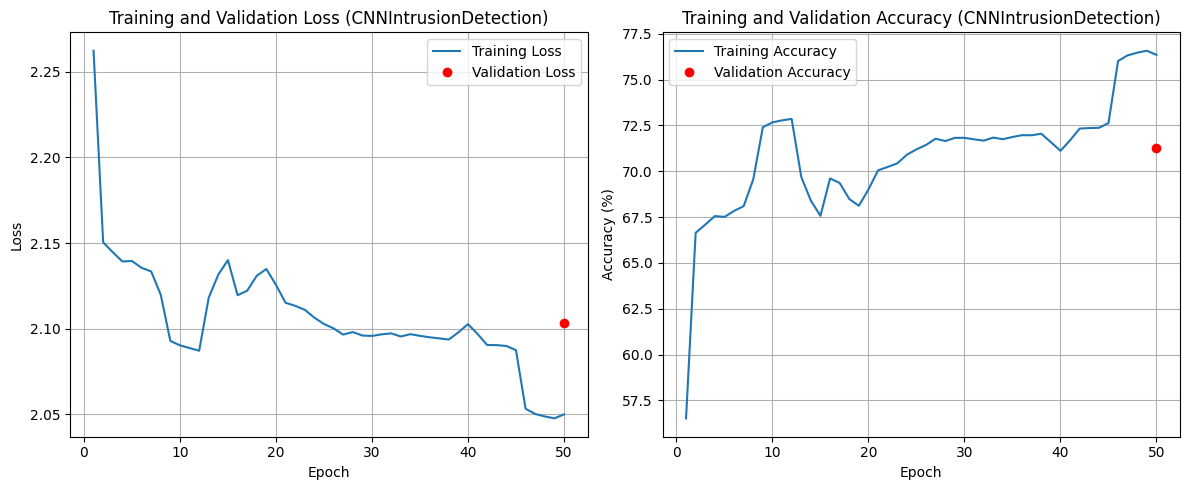

In [30]:

x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=str)
y_test = np.array(y_test, dtype=str)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

num_classes = len(np.unique(y_train_encoded))  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNIntrusionDetection(input_channels=1, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies = train_cnn(model, train_loader, criterion, optimizer, epochs=50, device=device)
val_losses, val_accuracy = evaluate_cnn(model, test_loader, criterion, device=device)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 51), train_losses, label="Training Loss")
plt.plot([50], val_losses, 'ro', label="Validation Loss")  
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss (CNNIntrusionDetection)")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, 51), train_accuracies, label="Training Accuracy")
plt.plot([50], [val_accuracy], 'ro', label="Validation Accuracy") 
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy (CNNIntrusionDetection)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [31]:
extra_tree(x_train,y_train, x_test, y_test)

Accuracy = 94.07%
Report = 
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.93      0.96    209569
                       Bot       0.04      1.00      0.09       192
                      DDoS       0.97      0.99      0.98     12707
             DoS GoldenEye       0.31      0.99      0.47      1013
                  DoS Hulk       0.94      0.99      0.96     17289
          DoS Slowhttptest       0.35      0.99      0.51       508
             DoS slowloris       0.61      0.99      0.75       550
               FTP-Patator       0.90      1.00      0.95       596
                Heartbleed       0.17      1.00      0.29         2
              Infiltration       0.00      0.75      0.01         4
                  PortScan       0.71      0.99      0.83      9105
               SSH-Patator       0.43      0.98      0.60       325
  Web Attack � Brute Force       0.32      0.75      0.44       154
Web Attack � Sql In

In [32]:
random_forest(x_train,y_train, x_test, y_test)

Accuracy = 93.65%
Report = 
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.93      0.96    209569
                       Bot       0.05      1.00      0.09       192
                      DDoS       0.96      0.99      0.97     12707
             DoS GoldenEye       0.29      0.99      0.44      1013
                  DoS Hulk       0.92      0.99      0.95     17289
          DoS Slowhttptest       0.33      0.99      0.50       508
             DoS slowloris       0.57      0.99      0.72       550
               FTP-Patator       0.96      0.99      0.98       596
                Heartbleed       0.14      1.00      0.25         2
              Infiltration       0.00      0.75      0.00         4
                  PortScan       0.70      0.99      0.82      9105
               SSH-Patator       0.41      0.98      0.57       325
  Web Attack � Brute Force       0.38      0.69      0.49       154
Web Attack � Sql In

In [33]:
xg_boost(x_train,y_train, x_test, y_test)

Accuracy = 93.38%
Report = 
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.92      0.96    209569
                       Bot       0.04      0.99      0.08       192
                      DDoS       0.96      0.99      0.98     12707
             DoS GoldenEye       0.29      0.99      0.45      1013
                  DoS Hulk       0.93      0.98      0.96     17289
          DoS Slowhttptest       0.30      0.99      0.47       508
             DoS slowloris       0.37      0.99      0.54       550
               FTP-Patator       0.82      1.00      0.90       596
                Heartbleed       0.22      1.00      0.36         2
              Infiltration       0.00      0.75      0.01         4
                  PortScan       0.72      0.99      0.84      9105
               SSH-Patator       0.42      0.98      0.59       325
  Web Attack � Brute Force       0.22      0.59      0.32       154
Web Attack � Sql In

In [ ]:
x_train = np.array(x_train, dtype=np.float32) 
x_test = np.array(x_test, dtype=np.float32)
y_train = np.array(y_train, dtype=str) 
y_test = np.array(y_test, dtype=str)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

x_train = torch.tensor(np.array(x_train, dtype=np.float32))
y_train = torch.tensor(y_train_encoded, dtype=torch.long)  
x_test = torch.tensor(np.array(x_test, dtype=np.float32))
y_test = torch.tensor(y_test_encoded, dtype=torch.long)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


num_classes = len(np.unique(y_train_encoded))
input_size = x_train.shape[1]


model = rnnLSTM(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.unsqueeze(1)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item() * batch_X.size(0)  # Accumulate loss
        
        _, predicted = torch.max(outputs, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()
    
    epoch_train_loss /= len(train_loader.dataset)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.unsqueeze(1)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            epoch_val_loss += loss.item() * batch_X.size(0)  # Accumulate loss
            
            _, predicted = torch.max(outputs, 1)
            total_val += batch_y.size(0)
            correct_val += (predicted == batch_y).sum().item()
    
    epoch_val_loss /= len(test_loader.dataset)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.2f}%, "
              f"Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_accuracy:.2f}%")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
